In [1]:
import re
import os
import cv2
import time
import random
import pickle
import scipy.ndimage
import scipy as sp
import numpy as np
import typing as t
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.stats import norm, kurtosis
from pandas.plotting import scatter_matrix
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier

import config as c
from utils.image_processing import crop_image, create_circular_mask, get_height_map, get_circular_std, get_circular_sum, get_circular_kurtosis, get_circular_ratio, get_bright_sum, get_ellipse_coefficient, get_histogram_matrix
from utils.dataset import get_train_data, get_test_data, get_private_test_data

plt.rcParams["figure.figsize"] = (10, 10)

In [100]:
df[(df.e==1)&(df.t==0)]

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4,particle_types_predict_ER3_NR6,particle_types_predict_ER10_NR20
10958,0,1,0.548872,2.636998,"[[103.14, 107.28, 97.72, 104.16, 108.36, 99.5,...",40.123863,126851.859375,-1.238615,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.068321,0.116498,0.039779,0.068595,0.134833,0,0
11150,0,1,0.433875,2.663998,"[[102.6, 95.8, 100.18, 104.700005, 100.26, 102...",40.105110,126796.039062,-1.173938,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.066428,0.116634,0.035820,0.066207,0.135818,0,0
13284,0,1,0.467933,2.458998,"[[101.04, 98.82, 97.04, 96.04, 104.86, 102.14,...",40.052864,126624.000000,-1.165698,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.067659,0.115382,0.036512,0.068123,0.134848,0,0


## Загружаем данные для обучения

In [2]:
df = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(80, 80), values_linear_transformation=False, center_by_max=False, short_load=False, distance_matrices=False, return_as_dataframe=True)

100%|██████████| 6758/6758 [00:00<00:00, 39520.36it/s]


## Отфильтровываем смещенные пятна и генерируем фичи

In [3]:
df_center_shifted = df[((df.circular_ratio<0.8)&(df.bright_sum>5))]
df = df[~((df.circular_ratio<0.8)&(df.bright_sum>5))]

df['img_80'] = df['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)
df['circular_std'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_std)(img) for img in tqdm(df['img_80']))
df['circular_sum'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_sum)(img) for img in tqdm(df['img_80']))
df['circular_kurtosis'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_kurtosis)(img) for img in tqdm(df['img_80']))
df['ellipse_coefficient'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_ellipse_coefficient)(img) for img in tqdm(df['img_80']))

100%|██████████| 8909/8909 [00:00<00:00, 10904.53it/s]


In [4]:
df.head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient
0,1,1,0.088028,2.457998,"[[100.1, 97.62, 101.4, 107.92, 101.0, 103.24, ...",40.117092,126840.476562,-1.556179,0.000000
1,1,1,0.009804,2.204998,"[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",40.101467,126793.382812,-1.307756,0.000000
2,1,20,0.895706,11.694000,"[[101.74, 101.1, 100.1, 97.880005, 100.74, 101...",43.719410,137182.718750,-1.396322,0.556596
3,1,6,0.889908,3.701998,"[[98.58, 100.66, 98.880005, 96.98, 101.22, 97....",40.605701,128325.453125,-1.368323,0.000000
4,1,20,0.895706,10.663999,"[[101.74, 104.08, 99.94, 95.28, 97.48, 97.58, ...",43.433891,136451.328125,-1.400491,0.529227


## Формируем усредненную матрицу гистограмм для каждой частицы и ищем расхождение между ней и гистограммами частиц

In [5]:
df['hist_matrix'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_histogram_matrix)(img, 16) for img in tqdm(df['img_80']))

mean_hist_matrix = []
for e in [3, 10]:
    mean_hist_matrix.append(np.mean(df[(df.t==0)&(df.e==e)]['hist_matrix']))
    
for e in [1, 6, 20]:
    mean_hist_matrix.append(np.mean(df[(df.t==1)&(df.e==e)]['hist_matrix']))
    
mean_hist_matrix = np.array(mean_hist_matrix)

for i in range(len(mean_hist_matrix)):
    df['error_'+str(i)] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix[i], hist_matrix) for hist_matrix in df['hist_matrix'])

100%|██████████| 8909/8909 [00:01<00:00, 4771.82it/s]


### Scatter matrix

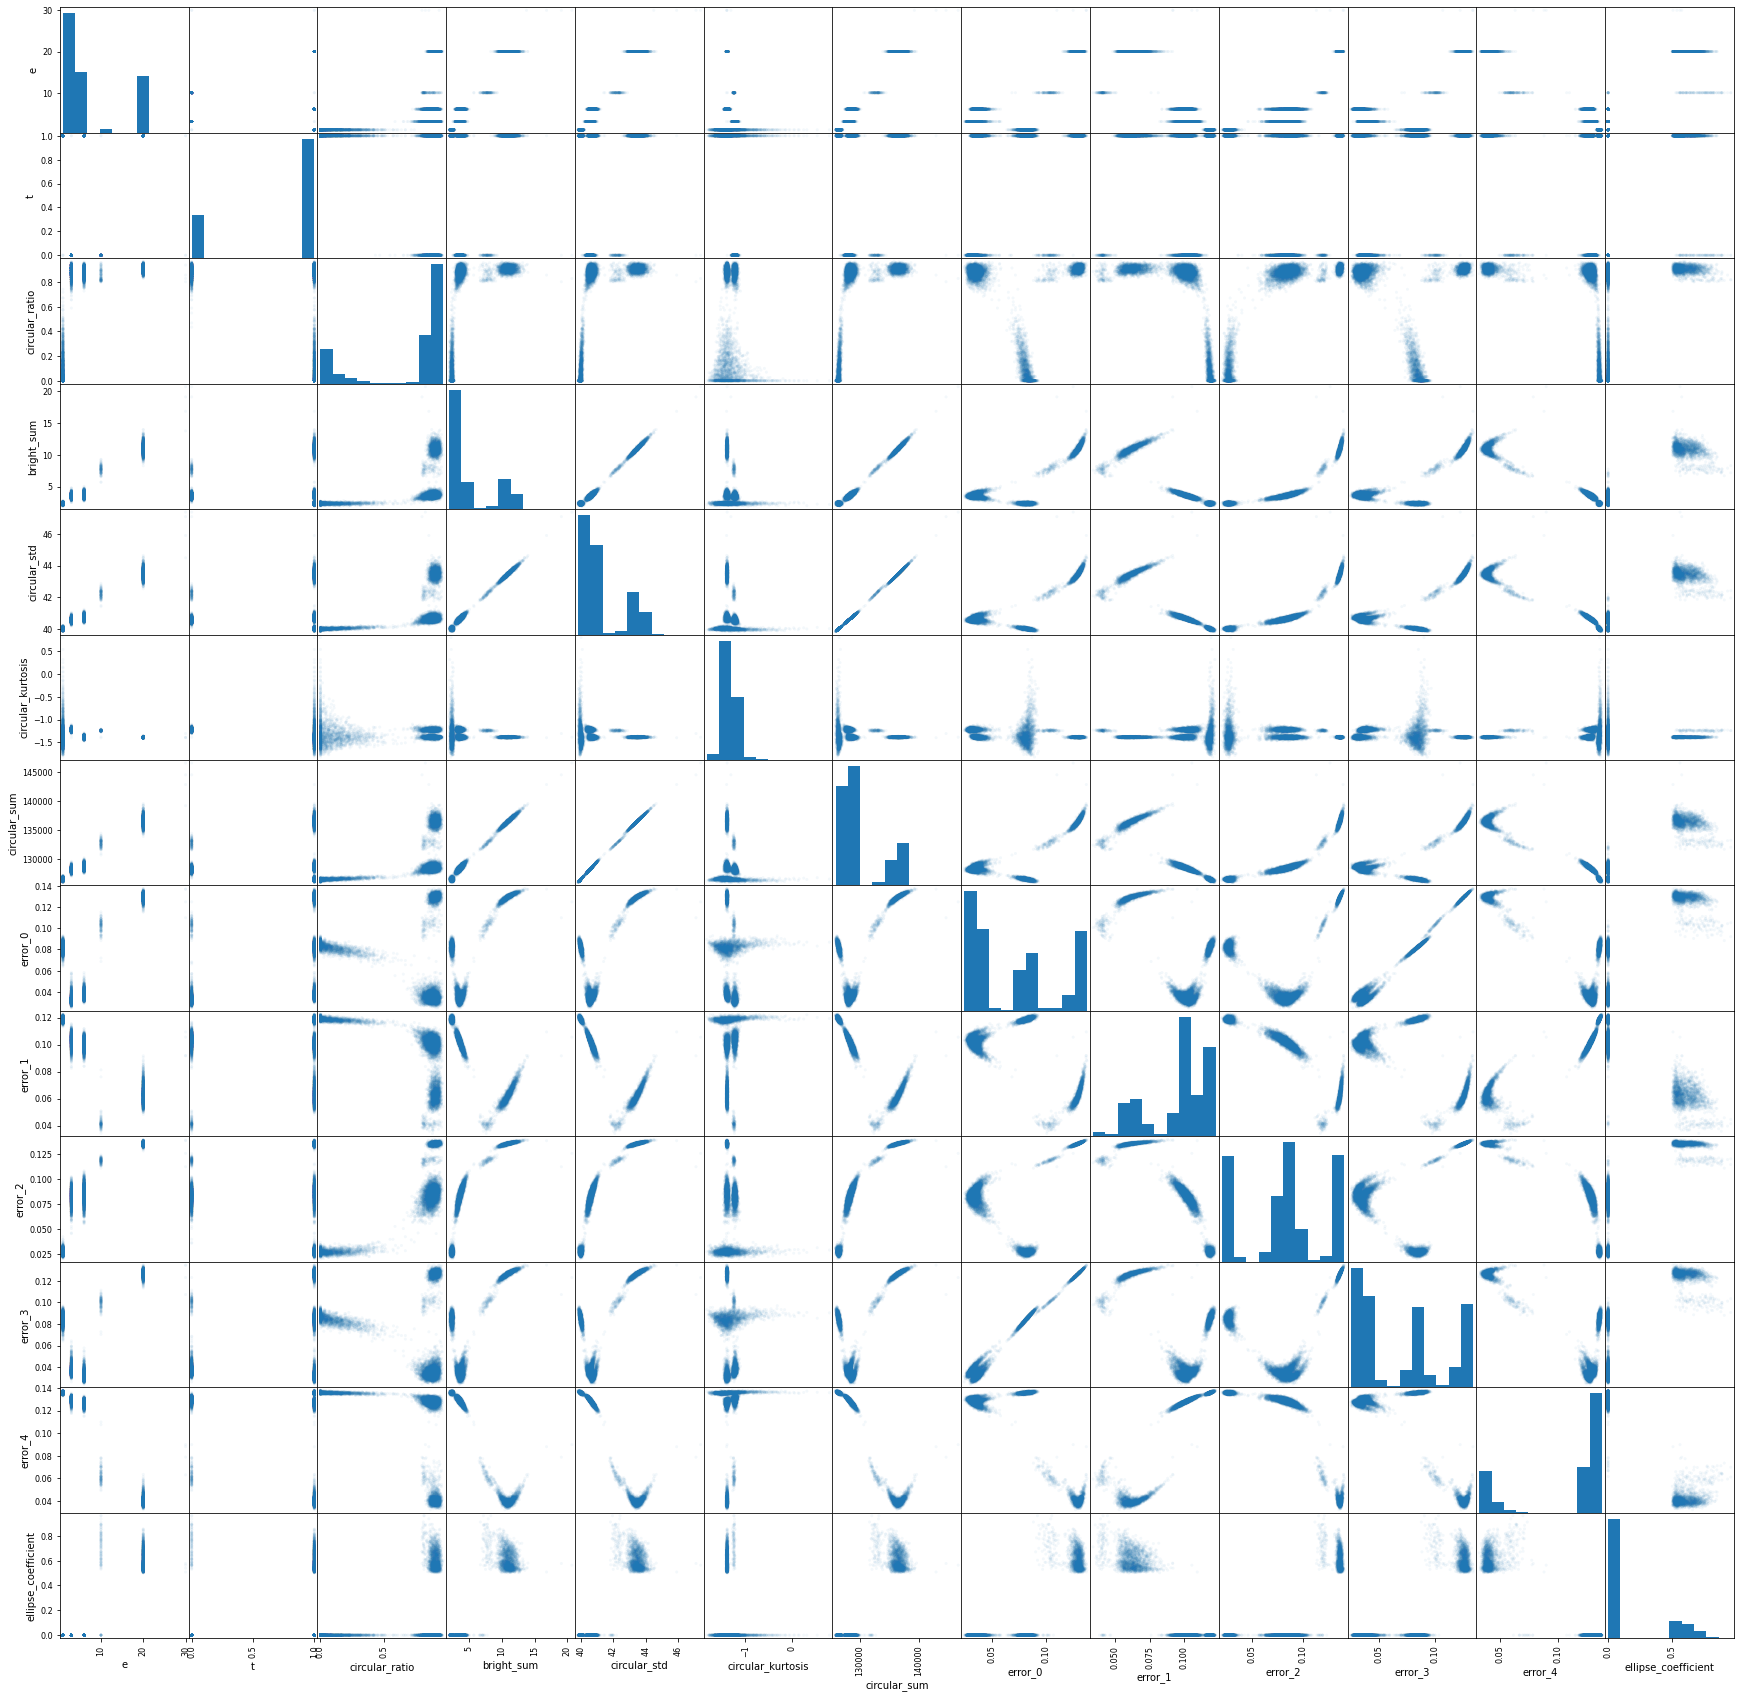

In [6]:
scatter_matrix(df[['e', 't', 'circular_ratio', 'bright_sum', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']], alpha=0.05, figsize=(30, 30));

In [7]:
df.head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4
0,1,1,0.088028,2.457998,"[[100.1, 97.62, 101.4, 107.92, 101.0, 103.24, ...",40.117092,126840.476562,-1.556179,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.082468,0.118320,0.028867,0.084458,0.134906
1,1,1,0.009804,2.204998,"[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",40.101467,126793.382812,-1.307756,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.078849,0.119419,0.029845,0.080030,0.136097
2,1,20,0.895706,11.694000,"[[101.74, 101.1, 100.1, 97.880005, 100.74, 101...",43.719410,137182.718750,-1.396322,0.556596,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.132114,0.068321,0.136251,0.129762,0.039316
3,1,6,0.889908,3.701998,"[[98.58, 100.66, 98.880005, 96.98, 101.22, 97....",40.605701,128325.453125,-1.368323,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.034932,0.102813,0.082102,0.030629,0.128451
4,1,20,0.895706,10.663999,"[[101.74, 104.08, 99.94, 95.28, 97.48, 97.58, ...",43.433891,136451.328125,-1.400491,0.529227,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.129646,0.060917,0.135954,0.127263,0.037500


# <------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->


# Обучение модели на классификацию ER3 и NR6, подходит так-же для (ER1/NR3) и (ER6/NR10)

In [66]:
df_ = df[(df.t==0)&(df.e==3) | (df.t==1)&(df.e==6)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)
print(len(x), np.mean(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=41)

4487 0.5001114330287497


#### CatBoostRegressor:

In [9]:
particle_types_model_ER3_NR6 = CatBoostRegressor(iterations=150,
                          learning_rate=3e-2,
                          l2_leaf_reg=1.0,  # any pos value
                          depth=6,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model_ER3_NR6.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model_ER3_NR6.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER3_NR6.predict(x_test)>0.5, y_test))

1.0 0.9994413407821229


#### LinearRegression:

In [10]:
particle_types_model_ER3_NR6 = LinearRegression().fit(x_train, y_train)
particle_types_model_ER3_NR6.score(x_train, y_train)


print(roc_auc_score(particle_types_model_ER3_NR6.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER3_NR6.predict(x_test)>0.5, y_test))

0.9985141085175473 0.9983271260086903


#### GradientBoostingClassifier

In [11]:
from sklearn import ensemble
particle_types_model_ER3_NR6 = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
particle_types_model_ER3_NR6.fit(x_train, y_train.ravel())

print(roc_auc_score(y_train, particle_types_model_ER3_NR6.predict(x_train)>0.5), roc_auc_score(y_test, particle_types_model_ER3_NR6.predict(x_test)>0.5))

1.0 0.9988901220865705


#### Гистограмма ответов модели:

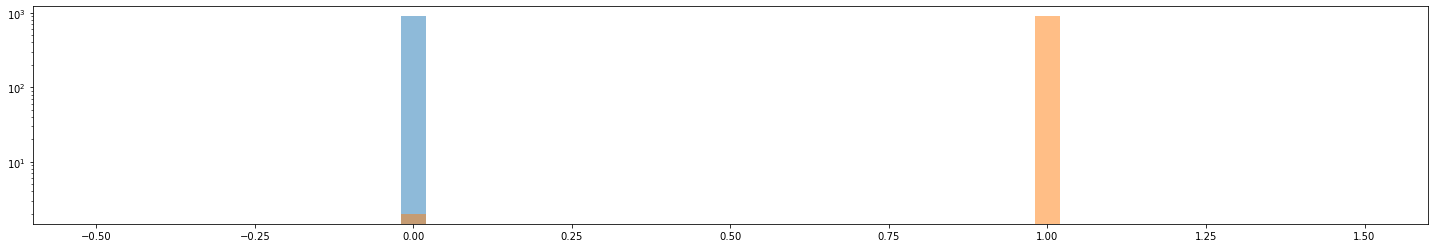

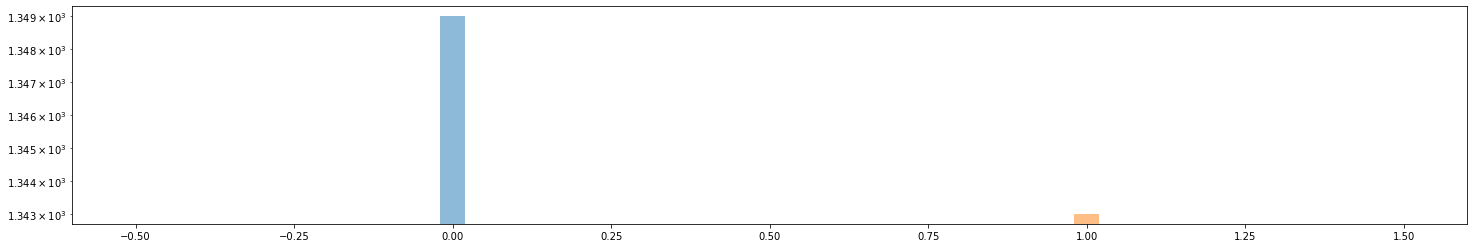

In [12]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

#### На каких частицах происходит ошибка:

In [13]:
df_ = df[(df.t==0)&(df.e==3) | (df.t==1)&(df.e==6)]
df_[df_.t!=(particle_types_model_ER3_NR6.predict(x)>0.5)*1].head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4
2272,1,6,0.861446,3.393998,"[[98.44, 100.340004, 99.520004, 93.340004, 97....",40.497616,127990.0000,-1.304313,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.036896,0.107588,0.070816,0.034281,0.131346
5549,1,6,0.889908,3.106998,"[[105.8, 96.3, 99.98, 103.54, 103.94, 98.64, 1...",40.444145,127823.6875,-1.284730,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.040621,0.107305,0.068991,0.039580,0.131844


#### Ошибка на классах, которые в обучении не использовались:

In [14]:
df_ = df[(df.t==0)&(df.e==10) | (df.t==1)&(df.e==10)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)

print(sum(y==0), sum(y==1), roc_auc_score(y, particle_types_model_ER3_NR6.predict(x)>0.5))

[134] [2] 1.0


In [15]:
x = df[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
df['particle_types_predict_ER3_NR6'] = particle_types_model_ER3_NR6.predict(x)

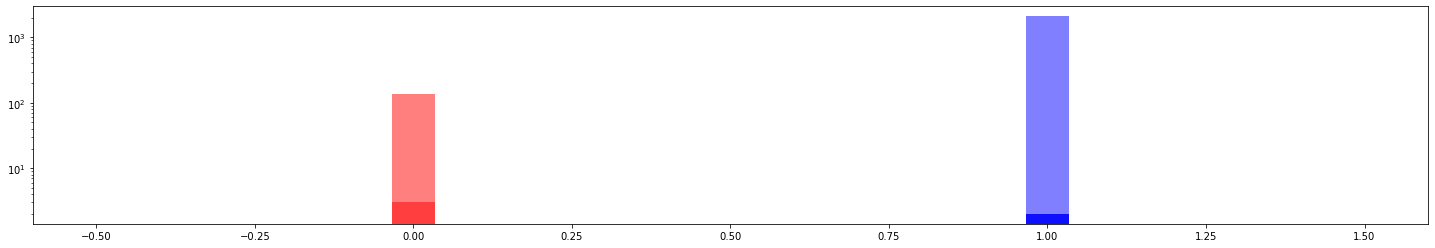

In [16]:
for e in [1, 6, 10, 20]:
    plt.hist(df[(df.e==e)&(df.t==0)].particle_types_predict_ER3_NR6, color='r', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)
    
for e in [3, 10, 20, 30]:
    plt.hist(df[(df.e==e)&(df.t==1)].particle_types_predict_ER3_NR6, color='b', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)

# <------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->


# Обучение модели на классификацию ER10 и NR20, подходит так-же для (ER6/NR10) и (ER20/NR30)

In [17]:
df_ = df[(df.t==0)&(df.e==10) | (df.t==1)&(df.e==20)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)
print(len(x), np.mean(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=41)

2239 0.9401518535060295


#### CatBoostRegressor:

In [18]:
particle_types_model_ER10_NR20 = CatBoostRegressor(iterations=150,
                          learning_rate=3e-2,
                          l2_leaf_reg=1.0,  # any pos value
                          depth=6,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model_ER10_NR20.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model_ER10_NR20.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER10_NR20.predict(x_test)>0.5, y_test))

1.0 1.0


#### LinearRegression:

In [19]:
particle_types_model_ER10_NR20 = LinearRegression().fit(x_train, y_train)
particle_types_model_ER10_NR20.score(x_train, y_train)


print(roc_auc_score(particle_types_model_ER10_NR20.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER10_NR20.predict(x_test)>0.5, y_test))

1.0 1.0


#### GradientBoostingClassifier

In [20]:
from sklearn import ensemble
particle_types_model_ER10_NR20 = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
particle_types_model_ER10_NR20.fit(x_train, y_train.ravel())

print(roc_auc_score(y_train, particle_types_model_ER10_NR20.predict(x_train)>0.5), roc_auc_score(y_test, particle_types_model_ER10_NR20.predict(x_test)>0.5))

1.0 1.0


#### Гистограмма ответов модели:

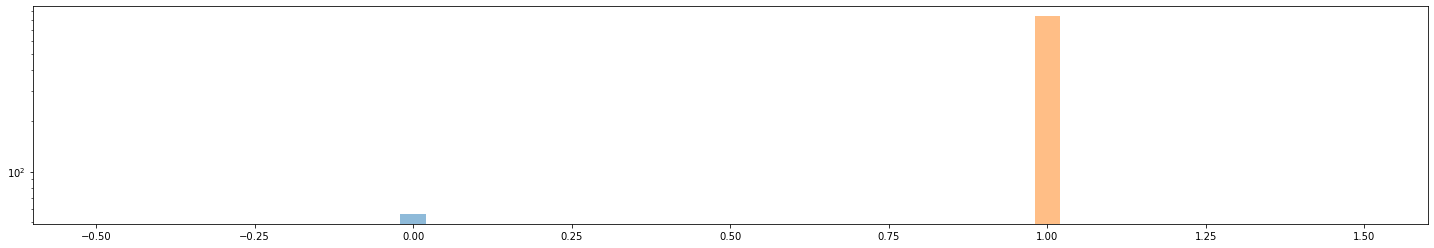

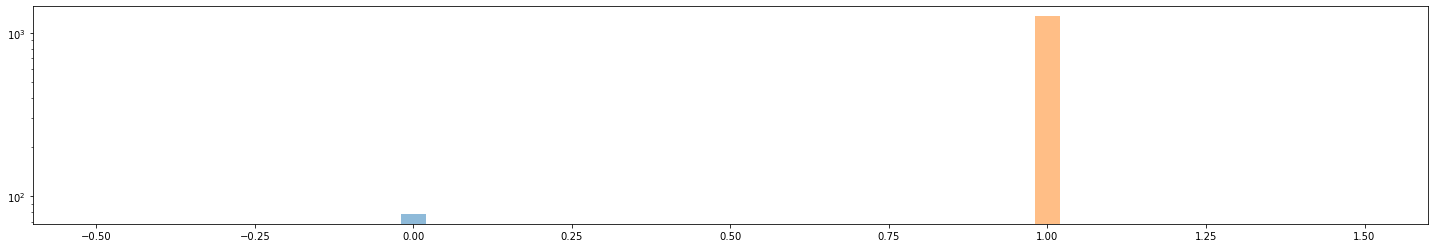

In [21]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

#### На каких частицах происходит ошибка:

In [22]:
df_ = df[(df.t==0)&(df.e==10) | (df.t==1)&(df.e==20)]
df_[df_.t!=(particle_types_model_ER3_NR6.predict(x)>0.5)*1].head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4,particle_types_predict_ER3_NR6


#### Ошибка на классах, которые в обучении не использовались:

In [23]:
df_ = df[(df.t==0)&(df.e==30) | (df.t==1)&(df.e==20)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)

print(sum(y==0), sum(y==1), roc_auc_score(y, particle_types_model_ER10_NR20.predict(x)>0.5))

[2] [2105] 0.75


In [24]:
x = df[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
df['particle_types_predict_ER10_NR20'] = particle_types_model_ER10_NR20.predict(x)

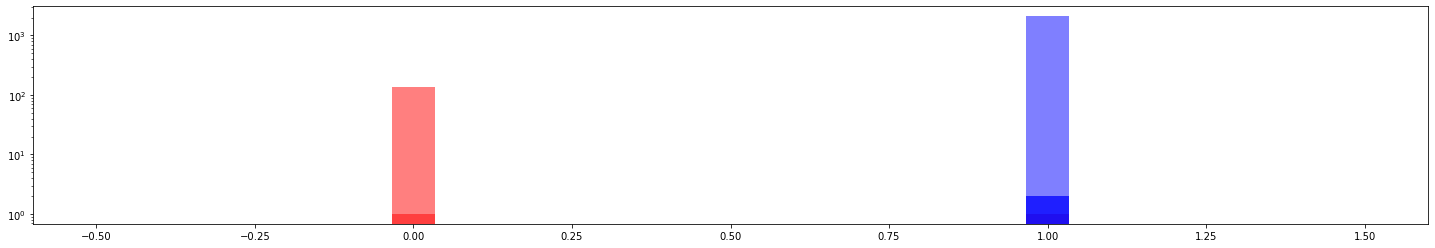

In [25]:
for e in [6, 10, 20, 30]:
    plt.hist(df[(df.e==e)&(df.t==0)].particle_types_predict_ER10_NR20, color='r', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)
    
for e in [10, 20, 30]:
    plt.hist(df[(df.e==e)&(df.t==1)].particle_types_predict_ER10_NR20, color='b', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)

# <------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->


In [72]:
pickle.dump(particle_types_model_ER3_NR6, open('checkpoints/particle_types_model_ER3_NR6.pickle', 'wb'))
pickle.dump(particle_types_model_ER10_NR20, open('checkpoints/particle_types_model_ER10_NR20.pickle', 'wb'))
pickle.dump(mean_hist_matrix, open('checkpoints/mean_hist_matrix.pickle', 'wb'))

In [73]:
particle_types_model_ER3_NR6 = pickle.load(open('checkpoints/particle_types_model_ER3_NR6.pickle', 'rb'))
particle_types_model_ER10_NR20 = pickle.load(open('checkpoints/particle_types_model_ER10_NR20.pickle', 'rb'))
mean_hist_matrix = pickle.load(open('checkpoints/mean_hist_matrix.pickle', 'rb'))

# <------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->


# Предсказание приватных данных

In [74]:
df_private = get_private_test_data((80, 80))

100%|██████████| 15058/15058 [00:05<00:00, 2674.13it/s]


## Отфильтровываем смещенные пятна и генерируем фичи

In [75]:
df_private['is_center_shifted'] = ((df_private.circular_ratio<0.8)&(df_private.bright_sum>3.5))

df_private['img_80'] = df_private['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)

df_private['circular_std'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_std)(img) for img in tqdm(df_private['img_80']))
df_private['circular_sum'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_sum)(img) for img in tqdm(df_private['img_80']))
df_private['circular_kurtosis'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_kurtosis)(img) for img in tqdm(df_private['img_80']))
df_private['ellipse_coefficient'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_ellipse_coefficient)(img) for img in tqdm(df_private['img_80']))

100%|██████████| 15058/15058 [00:00<00:00, 21238.42it/s]


In [76]:
df_private['hist_matrix'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_histogram_matrix)(img, 16) for img in tqdm(df_private['img_80']))

for i in range(len(mean_hist_matrix)):
    df_private['error_'+str(i)] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix[i], hist_matrix) for hist_matrix in df_private['hist_matrix'])

100%|██████████| 15058/15058 [00:03<00:00, 4651.84it/s]


In [77]:
mask = create_circular_mask(80, 80, radius=8)
df_private['sum'] = df_private['img_80'].map(lambda img: np.sum(img[mask])/np.sum(mask)-100.4)

In [78]:
df_private.head()

,file_names,id,circular_ratio,bright_sum,img_80,is_center_shifted,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4,sum
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96.png,00013a94f1fae3e5a33f8b44c2842c85f0483e96,0.878419,5.163998,"[[105.18, 100.1, 96.86, 101.62, 101.74, 103.66...",False,41.204472,130006.093750,-1.233512,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.065398,0.071110,0.104690,0.068206,0.106158,14.575551
1,0005564c011259402dcb6e3beb6e64d285124fa0.png,0005564c011259402dcb6e3beb6e64d285124fa0,0.024876,14.268999,"[[102.32, 99.64, 100.74, 98.380005, 100.880005...",True,39.812996,125358.609375,-1.016096,0.653406,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.076900,0.109661,0.063675,0.073627,0.124421,3.572696
2,0007520c8d8efade8feaafbf74fc7d206cdf229d.png,0007520c8d8efade8feaafbf74fc7d206cdf229d,0.931250,17.358000,"[[97.26, 100.840004, 99.54, 99.18, 95.86, 100....",False,46.063293,143187.906250,-1.386293,0.511125,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.135935,0.116221,0.137071,0.134230,0.096402,51.597065
3,000804a189f630cd980ff1543c0ef99d48cd6b34.png,000804a189f630cd980ff1543c0ef99d48cd6b34,0.437209,2.578998,"[[97.96, 103.28, 104.72, 98.6, 109.86, 103.26,...",False,40.118290,126833.804688,-1.335254,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.066761,0.115555,0.034697,0.067154,0.134359,2.418984
4,000eb12def5371089743dcfe401a8e399f5883fc.png,000eb12def5371089743dcfe401a8e399f5883fc,0.901538,17.177000,"[[99.86, 96.86, 105.1, 99.16, 101.98, 101.14, ...",False,45.978783,142960.562500,-1.390952,0.521056,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.135242,0.114089,0.136383,0.133324,0.092924,50.809847


### Выделяем границы

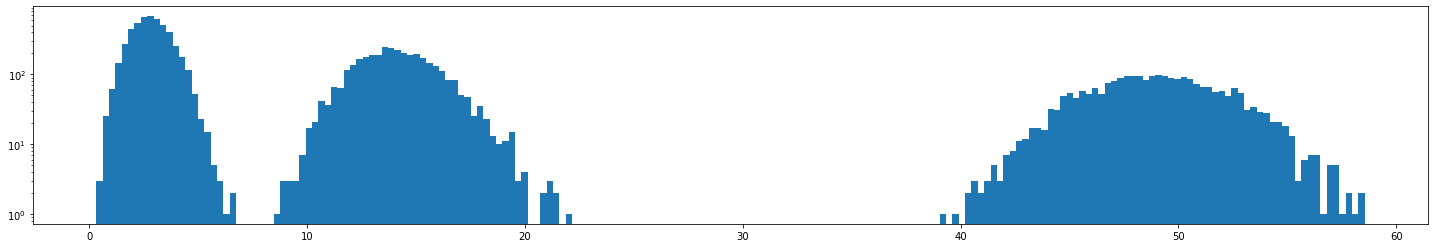

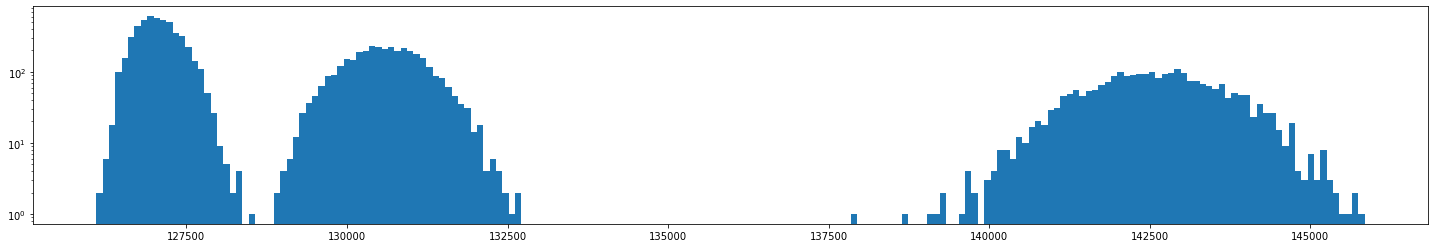

In [79]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[~df_private['is_center_shifted']]['sum'], bins=200, log=True)
plt.show()

plt.hist(df_private[~df_private['is_center_shifted']]['circular_sum'], bins=200, log=True)
plt.show()

In [80]:
np.sum(df_private[~df_private['is_center_shifted']]['sum']<7.5)

5042

In [81]:
np.sum(df_private[~df_private['is_center_shifted']]['sum']>30)

2522

In [82]:
np.sum((30>df_private[~df_private['is_center_shifted']]['sum'])&(df_private[~df_private['is_center_shifted']]['sum']>7.5))

3522

## Производим классификацию

In [83]:
class_borders = np.array([7.5, 30, 8.5])
predicting_class = np.array([[1, 6, 20], [3, 10, 30]])

In [84]:
x = df_private[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()

df_private['particle_types_predict_ER10_NR20'] = particle_types_model_ER10_NR20.predict(x)
df_private['particle_types_predict_ER3_NR6'] = particle_types_model_ER3_NR6.predict(x)

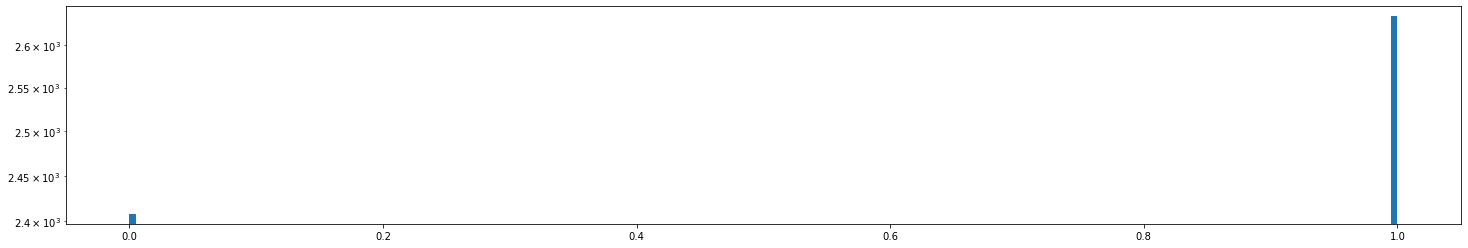

In [85]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['sum']<class_borders[0])]['particle_types_predict_ER3_NR6'], bins=200, log=True)
plt.show()

In [86]:
np.sum(df_private[(~df_private['is_center_shifted'])&(df_private['sum']<class_borders[0])]['particle_types_predict_ER3_NR6']<0.5)

2408

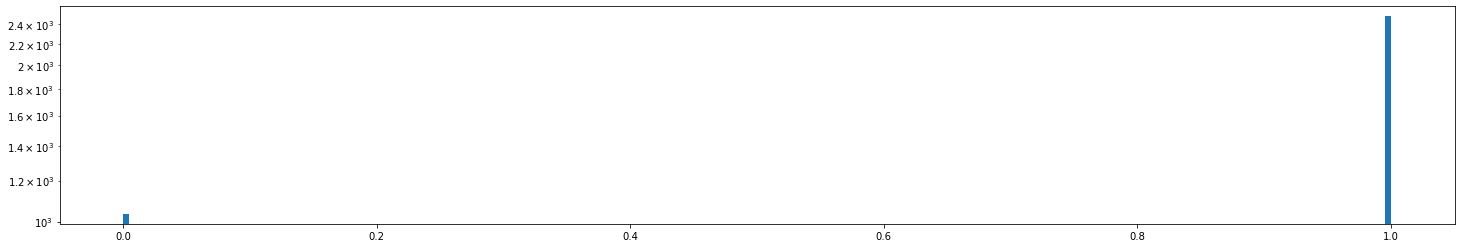

In [87]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['sum']>class_borders[0])&(df_private['sum']<class_borders[1])]['particle_types_predict_ER3_NR6'], bins=200, log=True)
plt.show()

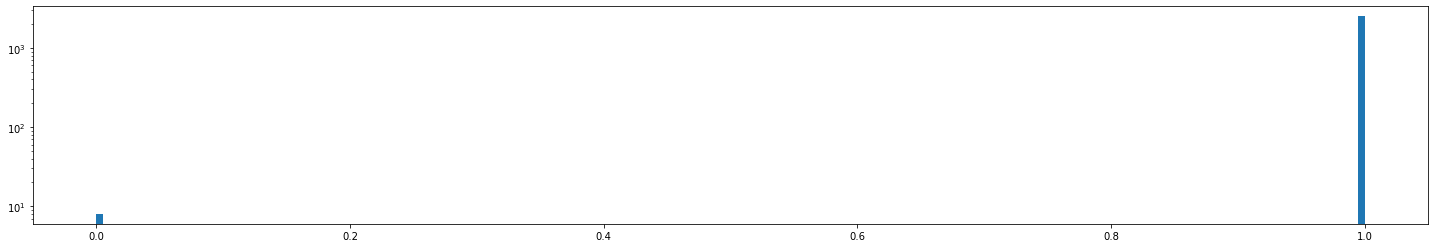

In [88]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['sum']>class_borders[1])]['particle_types_predict_ER10_NR20'], bins=200, log=True)
plt.show()

In [89]:
df_private['e'] = 0

df_private['e'] += predicting_class[0, 0] * ((~df_private['is_center_shifted'])&(df_private['sum']<class_borders[0])&(df_private['particle_types_predict_ER3_NR6']<0.5))
df_private['e'] += predicting_class[1, 0] * ((~df_private['is_center_shifted'])&(df_private['sum']<class_borders[0])&(df_private['particle_types_predict_ER3_NR6']>=0.5))

df_private['e'] += predicting_class[0, 1] * ((~df_private['is_center_shifted'])&(df_private['sum']>class_borders[0])&(df_private['sum']<class_borders[1])&(df_private['particle_types_predict_ER3_NR6']<0.5))
df_private['e'] += predicting_class[1, 1] * ((~df_private['is_center_shifted'])&(df_private['sum']>class_borders[0])&(df_private['sum']<class_borders[1])&(df_private['particle_types_predict_ER3_NR6']>=0.5))

df_private['e'] += predicting_class[0, 2] * ((~df_private['is_center_shifted'])&(df_private['sum']>class_borders[1])&(df_private['particle_types_predict_ER3_NR6']<0.5))
df_private['e'] += predicting_class[1, 2] * ((~df_private['is_center_shifted'])&(df_private['sum']>class_borders[1])&(df_private['particle_types_predict_ER3_NR6']>=0.5))

df_private['e'] += predicting_class[0, 1] * ((df_private['is_center_shifted'])&(df_private['bright_sum']<class_borders[2]))
df_private['e'] += predicting_class[0, 2] * ((df_private['is_center_shifted'])&(df_private['bright_sum']>class_borders[2]))

df_private['t'] =  ((~df_private['is_center_shifted'])&(df_private['sum']<class_borders[0])&(df_private['particle_types_predict_ER3_NR6']>0.5)) |\
                    ((~df_private['is_center_shifted'])&(df_private['sum']>class_borders[0])&(df_private['sum']<class_borders[1])&(df_private['particle_types_predict_ER3_NR6']>0.5)) |\
                    ((~df_private['is_center_shifted'])&(df_private['sum']>class_borders[1])&(df_private['particle_types_predict_ER3_NR6']>0.5))

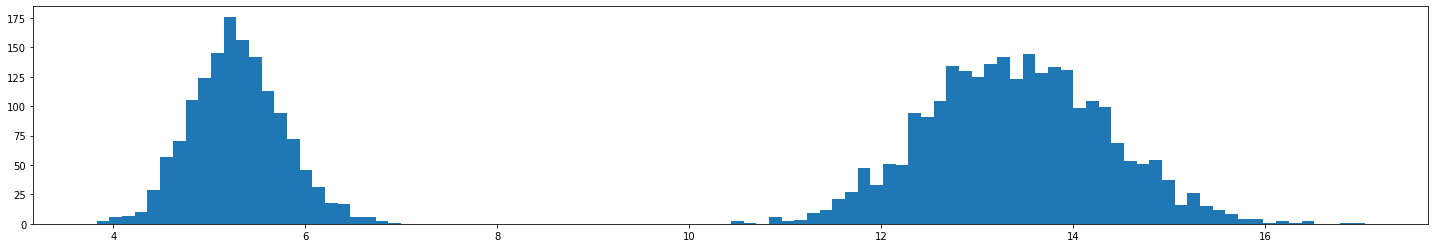

In [90]:
plt.hist(df_private[df_private['is_center_shifted']]['bright_sum'], bins=100)
plt.show()

In [91]:
df_private.e.value_counts()

3     2634
20    2544
30    2515
10    2487
6     2470
1     2408
Name: e, dtype: int64

In [92]:
df_test = get_test_data((80, 80))

100%|██████████| 1502/1502 [00:00<00:00, 3584.73it/s]


In [96]:
submission = pd.concat([df_private, df_test])#pd.merge(submission, df_test, how="outer", on=['id'])
submission = submission.fillna(1, axis=0)

In [97]:
submission = submission[['id', 't', 'e']]
submission.t = submission.t.astype(int)
submission.e = submission.e.astype(int)
submission = submission.rename(columns={"t": "classification_predictions", "e": "regression_predictions"})

In [98]:
submission.to_csv('submission.csv', index=False)

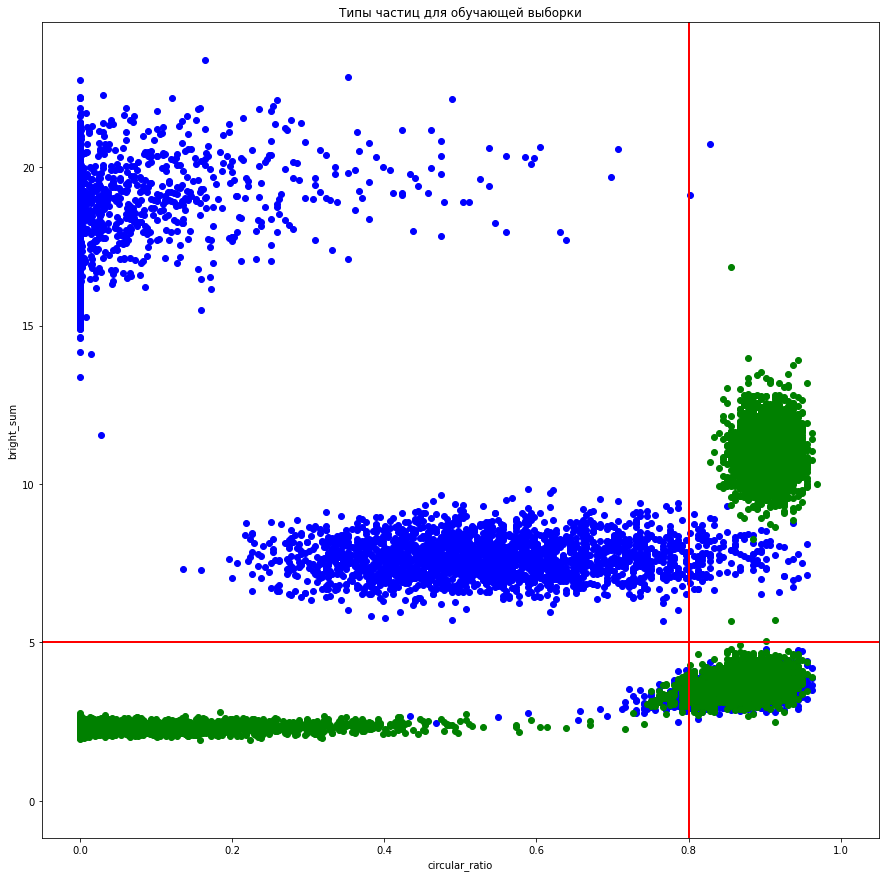

In [163]:
plt.rcParams["figure.figsize"] = (15, 15)

points = df[df.t==0][['circular_ratio', 'bright_sum']].to_numpy()
plt.scatter(points[:,0], points[:,1], color='b')

points = df[df.t==1][['circular_ratio', 'bright_sum']].to_numpy()
plt.scatter(points[:,0], points[:,1], color='g')

plt.axline((0.8, 0), (0.8, 1), linewidth=2, color='r')
plt.axline((0, 5), (1, 5), linewidth=2, color='r')
plt.title('Типы частиц для обучающей выборки')
plt.xlabel('circular_ratio')
plt.ylabel('bright_sum')
plt.show()

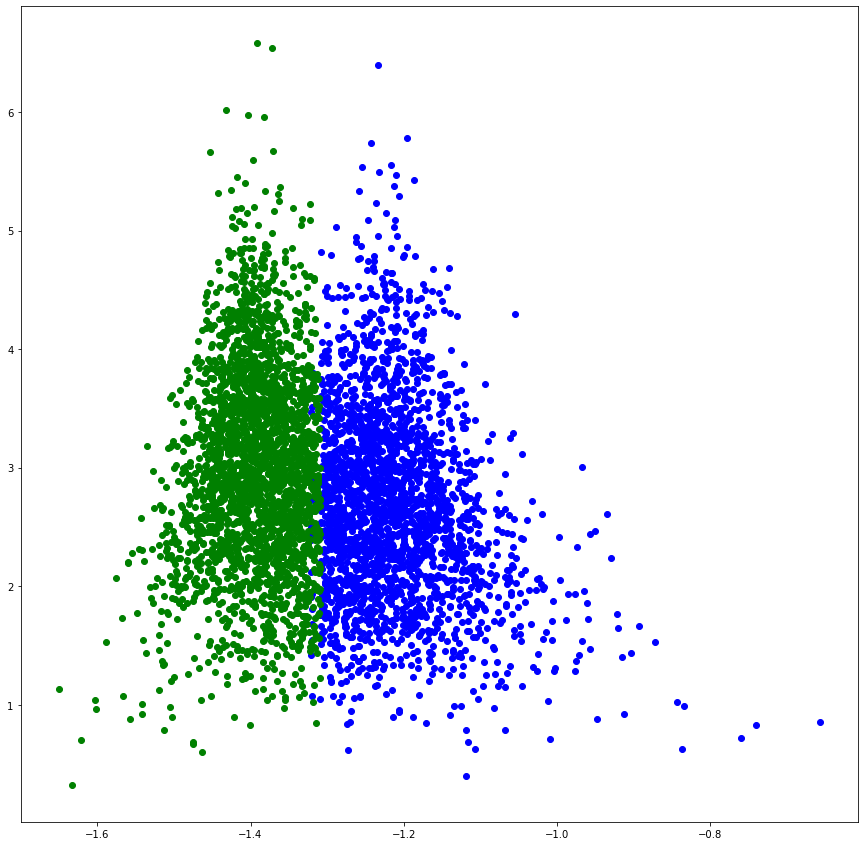

In [59]:
plt.rcParams["figure.figsize"] = (15, 15)

points = df_private[df_private.e==1][['circular_kurtosis', 'sum']].to_numpy()
plt.scatter(points[:,0], points[:,1], color='b')

points = df_private[df_private.e==3][['circular_kurtosis', 'sum']].to_numpy()
plt.scatter(points[:,0], points[:,1], color='g')

plt.show()

In [53]:
df

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4,particle_types_predict_ER3_NR6,particle_types_predict_ER10_NR20
0,1,1,0.088028,2.457998,"[[100.1, 97.62, 101.4, 107.92, 101.0, 103.24, ...",40.117092,126840.476562,-1.556179,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.082468,0.118320,0.028867,0.084458,0.134906,1,1
1,1,1,0.009804,2.204998,"[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",40.101467,126793.382812,-1.307756,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.078849,0.119419,0.029845,0.080030,0.136097,0,0
2,1,20,0.895706,11.694000,"[[101.74, 101.1, 100.1, 97.880005, 100.74, 101...",43.719410,137182.718750,-1.396322,0.556596,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.132114,0.068321,0.136251,0.129762,0.039316,1,1
3,1,6,0.889908,3.701998,"[[98.58, 100.66, 98.880005, 96.98, 101.22, 97....",40.605701,128325.453125,-1.368323,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.034932,0.102813,0.082102,0.030629,0.128451,1,1
4,1,20,0.895706,10.663999,"[[101.74, 104.08, 99.94, 95.28, 97.48, 97.58, ...",43.433891,136451.328125,-1.400491,0.529227,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.129646,0.060917,0.135954,0.127263,0.037500,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13275,0,3,0.884146,3.268998,"[[101.92, 100.3, 97.72, 106.64, 99.520004, 99....",40.467087,127879.562500,-1.232670,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.031587,0.105823,0.076899,0.033124,0.130872,0,0
13277,0,3,0.937304,3.569998,"[[105.020004, 98.8, 103.6, 110.32, 99.94, 98.6...",40.597385,128262.484375,-1.237036,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.029992,0.099661,0.084814,0.035813,0.128430,0,0
13278,0,3,0.937304,3.802998,"[[101.380005, 99.200005, 101.86, 108.78, 100.2...",40.642136,128412.523438,-1.228417,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.032020,0.100869,0.083936,0.038918,0.128730,0,0
13279,0,3,0.878419,3.220398,"[[99.24, 100.200005, 96.18, 103.98, 97.32, 99....",40.631889,128396.984375,-1.277298,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.034540,0.103902,0.079348,0.034297,0.128734,0,0


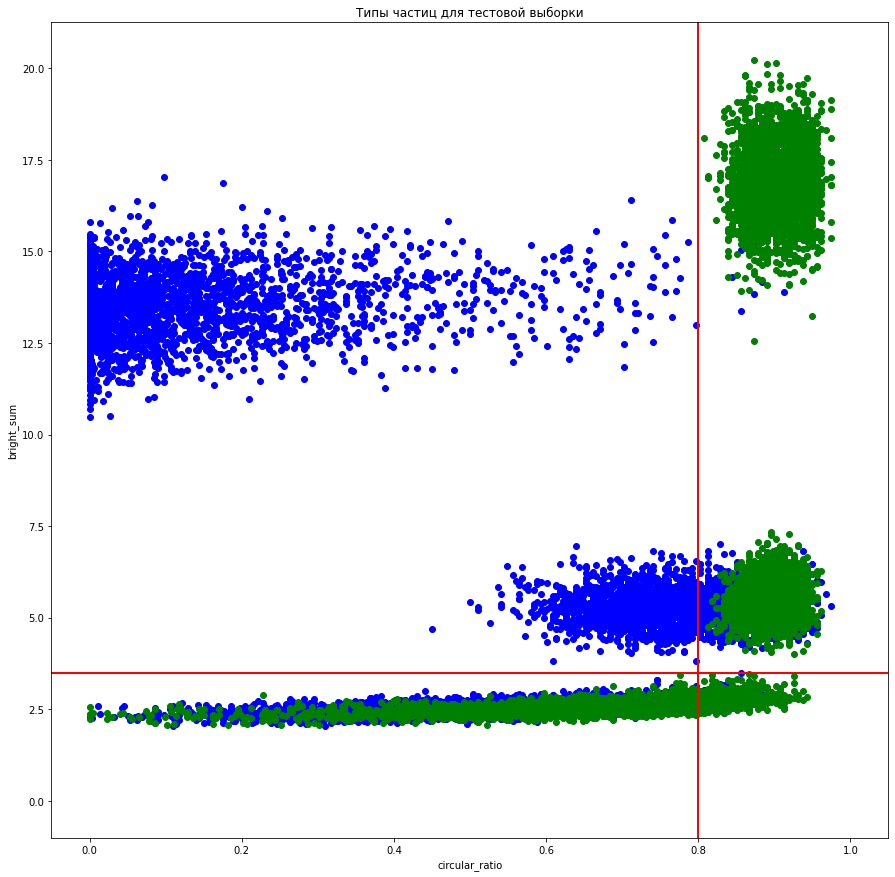

In [51]:
plt.rcParams["figure.figsize"] = (15, 15)

points = df_private[df_private.t==0][['circular_ratio', 'bright_sum']].to_numpy()
plt.scatter(points[:,0], points[:,1], color='b')

points = df_private[df_private.t==1][['circular_ratio', 'bright_sum']].to_numpy()
plt.scatter(points[:,0], points[:,1], color='g')


plt.axline((0.8, 0), (0.8, 1), linewidth=2, color='r')
plt.axline((0, 3.5), (1, 3.5), linewidth=2, color='r')
plt.title('Типы частиц для тестовой выборки')
plt.xlabel('circular_ratio')
plt.ylabel('bright_sum')
plt.show()

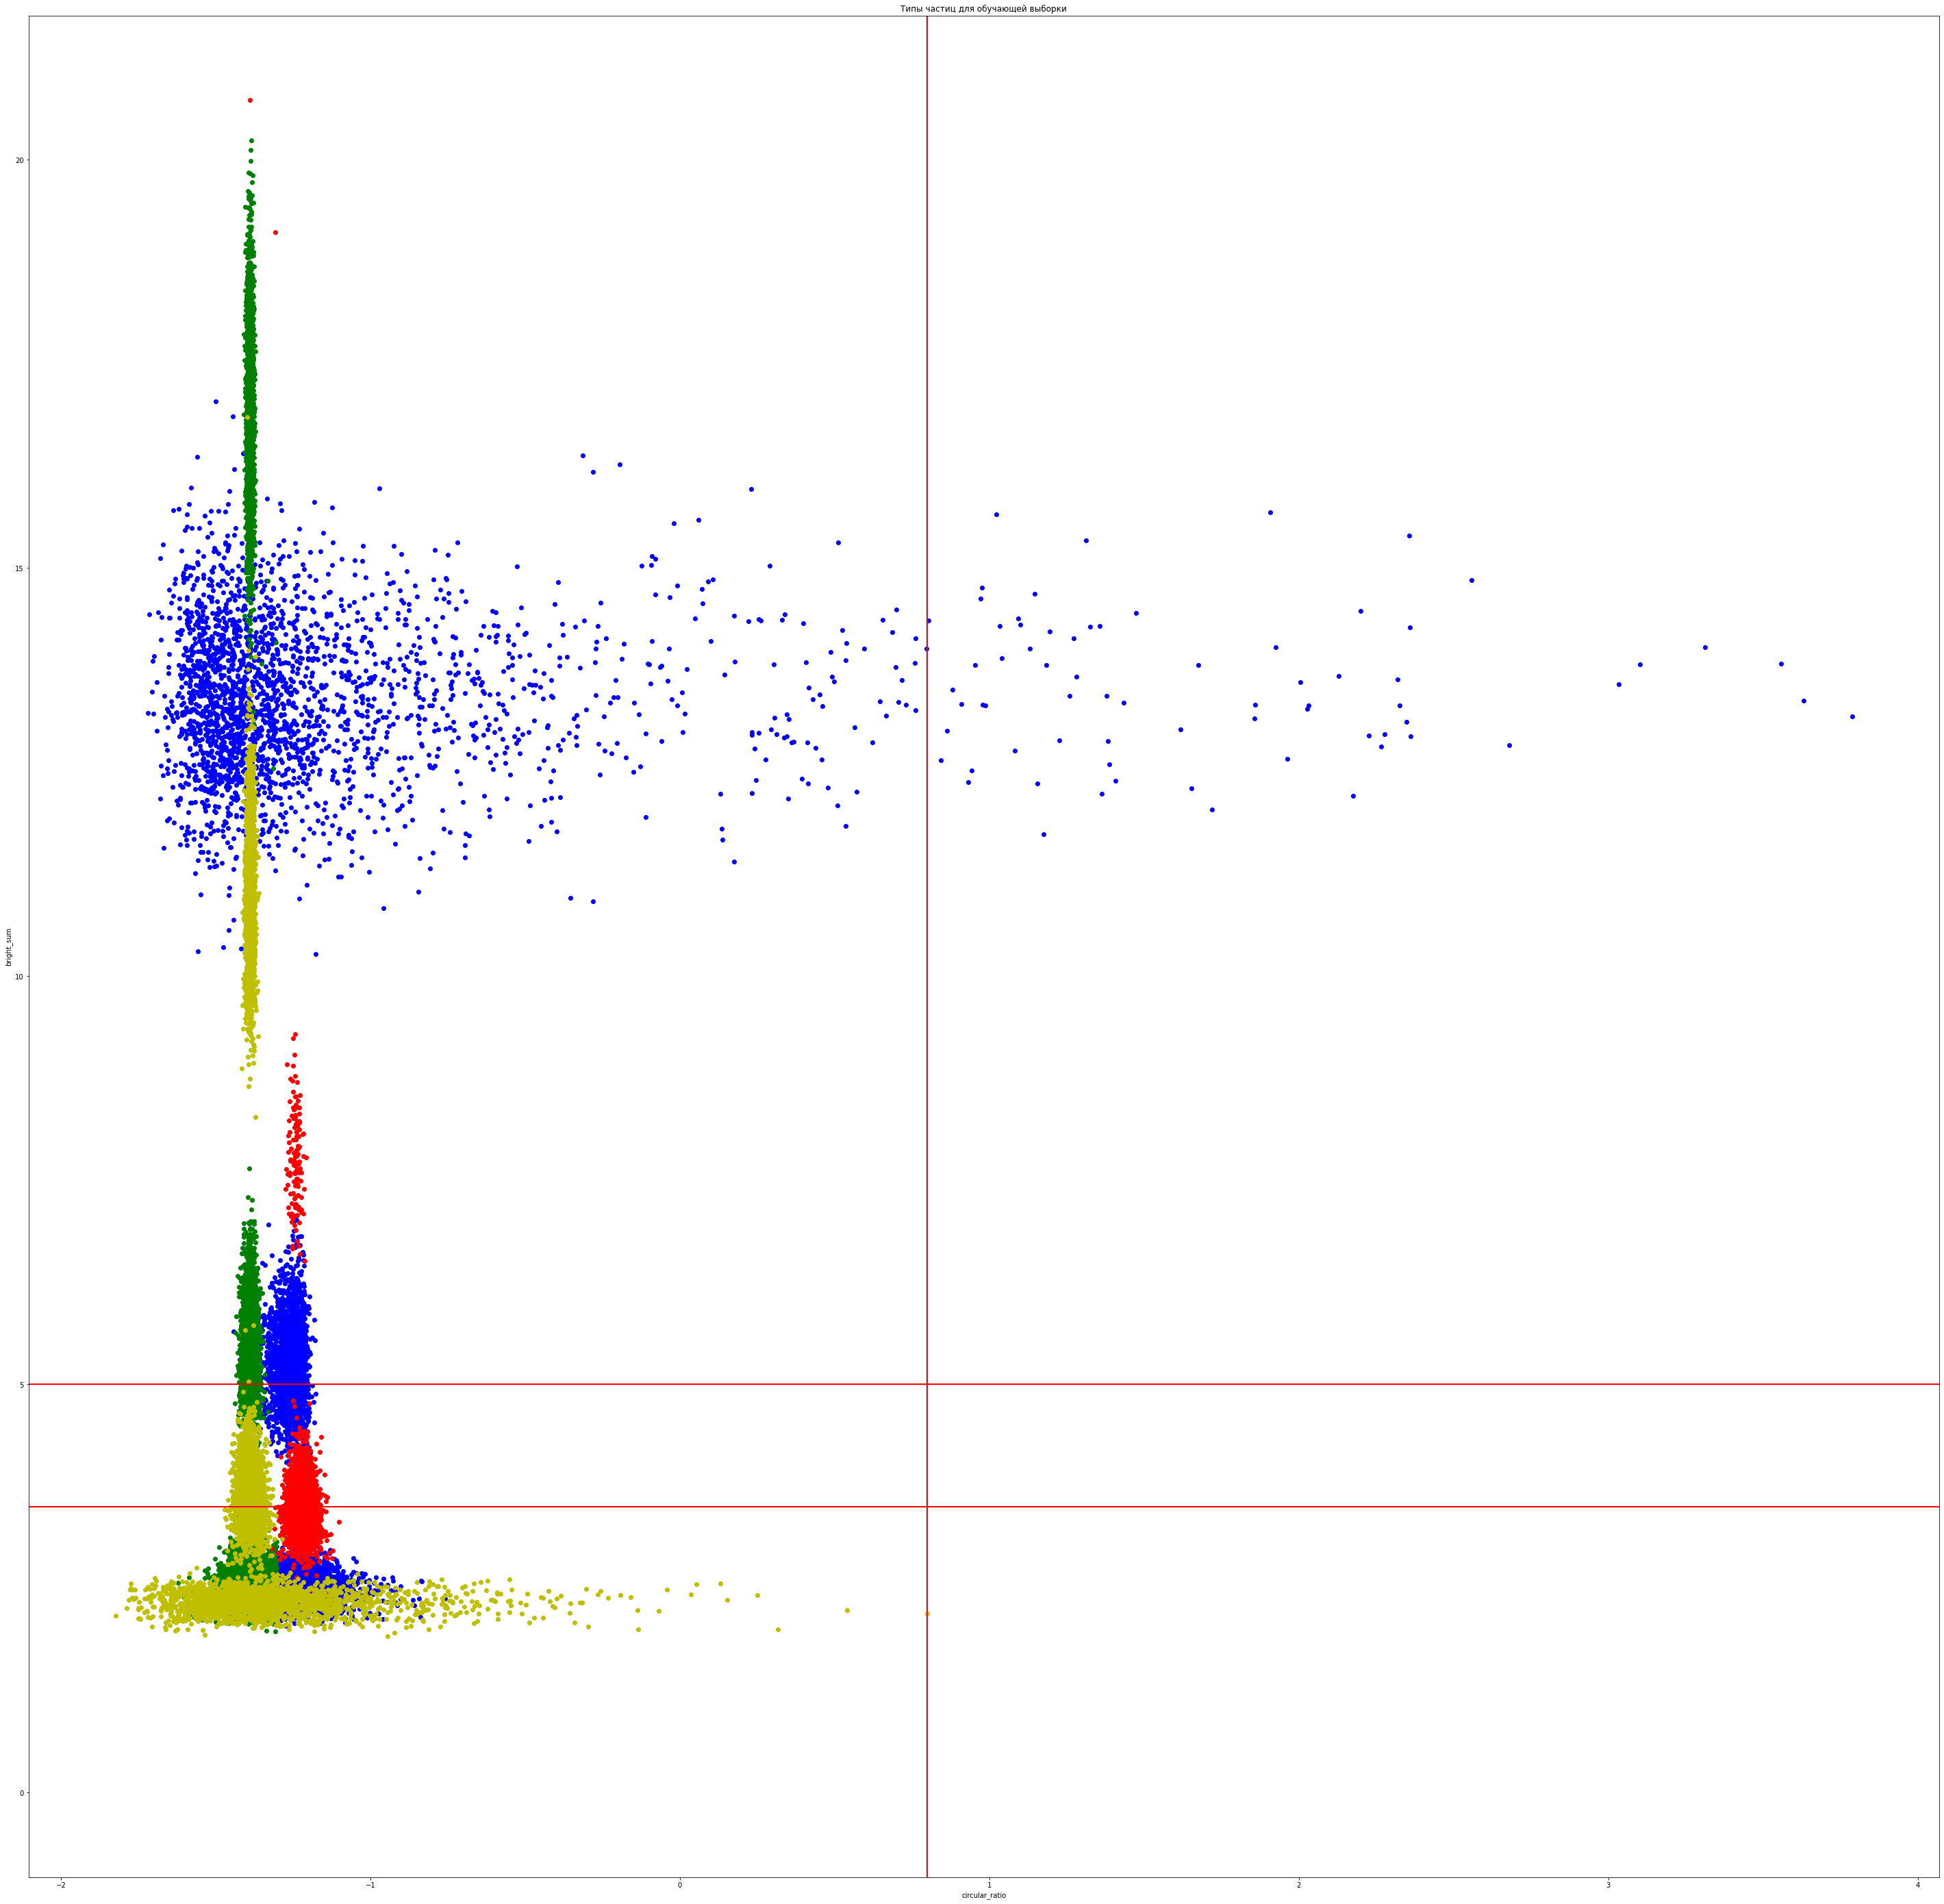

In [91]:
plt.rcParams["figure.figsize"] = (50, 50)

points = df_private[df_private.t==0][['circular_kurtosis', 'bright_sum']].to_numpy()
plt.scatter(points[:,0], points[:,1], color='b')

points = df_private[df_private.t==1][['circular_kurtosis', 'bright_sum']].to_numpy()
plt.scatter(points[:,0], points[:,1], color='g')


plt.axline((0.8, 0), (0.8, 1), linewidth=2, color='r')
plt.axline((0, 3.5), (1, 3.5), linewidth=2, color='r')




points = df[df.t==0][['circular_kurtosis', 'bright_sum']].to_numpy()
plt.scatter(points[:,0], points[:,1], color='r')

points = df[df.t==1][['circular_kurtosis', 'bright_sum']].to_numpy()
plt.scatter(points[:,0], points[:,1], color='y')

plt.axline((0.8, 0), (0.8, 1), linewidth=2, color='r')
plt.axline((0, 5), (1, 5), linewidth=2, color='r')
plt.title('Типы частиц для обучающей выборки')
plt.xlabel('circular_ratio')
plt.ylabel('bright_sum')
plt.show()